## Content
<a href='#introduction'>Introduction</a><br>
<a href='#preprocess'>Data Preprocessing</a><br>
<a href='#edafeatures'>EDA and Feature Engineering</a><br>
<a href='#model'>Model and Evaluation</a><br>
<a href='#submit'>Submission</a>

<a id='introduction'></a>

## Introduction

All movie buffs had a conversation with friends before movie release:'This movie is going to be hit','This is going to flop'
.Data enthusiast in me always wondered,How the hell they are predicting it.They all had answers:'it's Avenger movie','Tom Cruise is starring in it' etc.
Well,now I've got the opportunity to observe it myself,maybe next time I'll try to comment on success of movie and maybe they'll be impressed.

This is my first Kaggle kernel.So very excited and looking forward to feedback from kaggle community.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import ast
from tqdm import tqdm
import time
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,chi2
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from types import FunctionType
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
seed = 123

In [2]:
# Data import
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
print('train dataset size:', train.shape)
print('test dataset size:', test.shape)

train dataset size: (3000, 23)
test dataset size: (4398, 22)


<a id='preprocess'></a>

## Data Preprocessing

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [4]:
train.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


Let's summarize meaning of each column

In [5]:
'''Total rows:3000
Data columns (total 23 columns):
id  &nbsp;                       3000 non-null int64   unique id given to movie  
belongs_to_collection    604 non-null object   title,poster path etc given in jason format  
budget                   3000 non-null int64   budget of the movie,assuming in USD  
genres                   2993 non-null object  one movie can have multiple genre given in list of dictionaries  
homepage                 946 non-null object   homepage of production company,I think  
imdb_id                  3000 non-null object  unique id given to movie on IMDB website  
original_language        3000 non-null object  original_language of the movie 
original_title           3000 non-null object  title of the movie 
overview                 2992 non-null object  short overview about movie story 
popularity               3000 non-null float64 score based on popularity,how this score is calculated is not given to us
poster_path              2999 non-null object  path to image of movie poster
production_companies     2844 non-null object  one movie can have multiple production companies  
production_countries     2945 non-null object  name of the country where movie production took place 
release_date             3000 non-null object  movie release date in mm/dd/yy format
runtime                  2998 non-null float64 movie runtime in minutes
spoken_languages         2980 non-null object  language spoken in movie given in list of dictionary
status                   3000 non-null object  Status of the movie.Either 'Released' or 'Rumored'
tagline                  2403 non-null object  Tagline given in String format
title                    3000 non-null object  Title of the movie
Keywords                 2724 non-null object  List of keywords related to movie plot
cast                     2987 non-null object  List of cast and its details
crew                     2984 non-null object  list of crew and their detail
revenue                  3000 non-null int64   revenue earned by the movie,this is our taget variable.'''

"Total rows:3000\nData columns (total 23 columns):\nid  &nbsp;                       3000 non-null int64   unique id given to movie  \nbelongs_to_collection    604 non-null object   title,poster path etc given in jason format  \nbudget                   3000 non-null int64   budget of the movie,assuming in USD  \ngenres                   2993 non-null object  one movie can have multiple genre given in list of dictionaries  \nhomepage                 946 non-null object   homepage of production company,I think  \nimdb_id                  3000 non-null object  unique id given to movie on IMDB website  \noriginal_language        3000 non-null object  original_language of the movie \noriginal_title           3000 non-null object  title of the movie \noverview                 2992 non-null object  short overview about movie story \npopularity               3000 non-null float64 score based on popularity,how this score is calculated is not given to us\nposter_path              2999 non-null 

Let's create set of columns which we think will be useful for revenue prediction

In [6]:
columns_to_keep = set()

#### Clean Dictionary features

There are multiple features with dictionary data stored as String.Let's create common method to process these features

In [7]:
#This method will clean feature with dictionary data.
#Create new feature with total number of values,onehot encoded feature
def clean_dictionary_features(feature_name,train,test):
    #convert string to dictionary
    train[feature_name] = train[feature_name].apply(lambda x:{} if pd.isna(x) else ast.literal_eval(x))
    test[feature_name] = test[feature_name].apply(lambda x:{} if pd.isna(x) else ast.literal_eval(x))
    
    #create new feature of total count of values
    train[feature_name+'_number'] = train[feature_name].apply(lambda x:len(x) if x!={} else 0)
    test[feature_name+'_number'] = test[feature_name].apply(lambda x:len(x) if x!={} else 0)
    columns_to_keep.add(feature_name+'_number')
    
    #get list of all values
    list_of_values = list(train[feature_name].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

    train[feature_name+'_all'] = train[feature_name].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    top_values = [m[0] for m in Counter([i for j in list_of_values for i in j]).most_common(10)]
    
    #Create one hot encoded feature
    for val in top_values:
        train[feature_name +'_'+val] = train[feature_name+'_all'].apply(lambda x: 1 if val in x else 0)
        columns_to_keep.add(feature_name +'_'+val)
    
    test[feature_name+'_all'] = test[feature_name].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for val in top_values:
        test[feature_name +'_'+val] = test[feature_name+'_all'].apply(lambda x: 1 if val in x else 0)
    
    #Create Lable encoded feature 
    le = LabelEncoder()
    le.fit(list(train[feature_name+'_all'].fillna('')) + list(test[feature_name+'_all'].fillna('')))
    train[feature_name+'_all'] = le.transform(train[feature_name+'_all'].fillna('').astype(str))
    test[feature_name+'_all'] = le.transform(test[feature_name+'_all'].fillna('').astype(str))
    columns_to_keep.add(feature_name+'_all')
    return train,test

In [8]:
train,test = clean_dictionary_features('genres',train,test)
train,test = clean_dictionary_features('production_companies',train,test)
train,test = clean_dictionary_features('production_countries',train,test)
train,test = clean_dictionary_features('spoken_languages',train,test)
train,test = clean_dictionary_features('Keywords',train,test)
train,test = clean_dictionary_features('cast',train,test)
train,test = clean_dictionary_features('crew',train,test)


#### Handle missing values

In [9]:
print("-"*40,'\n',train.isnull().sum())
print("-"*40,'\n',test.isnull().sum())

---------------------------------------- 
 id                                 0
belongs_to_collection           2396
budget                             0
genres                             0
homepage                        2054
imdb_id                            0
original_language                  0
original_title                     0
overview                           8
popularity                         0
poster_path                        1
production_companies               0
production_countries               0
release_date                       0
runtime                            2
spoken_languages                   0
status                             0
tagline                          597
title                              0
Keywords                           0
cast                               0
crew                               0
revenue                            0
genres_number                      0
genres_all                         0
genres_Drama                    

There are null values in belongs_to_collection,homepage, tagline etc columns.But we will handle them when we explore those
features individually.

<a id='edafeatures'></a>

## EDA and Feature Engineering

#### Explore: belongs_to_collection vs revenue

In [10]:
train.belongs_to_collection.describe()

count                                                   604
unique                                                  422
top       [{'id': 645, 'name': 'James Bond Collection', ...
freq                                                     16
Name: belongs_to_collection, dtype: object

In [11]:
train['belongs_to_collection'][0]

"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]"

I don't think this feature with so many empty values will be useful to determine revenue.However,I see James Bond Collection repeated 16 times.So having collection may mean movie is part of franchise or it is famous one.

So let's create categorical feature-if movie belongs to collection.

In [12]:
train['got_collection'] = train['belongs_to_collection'].apply(lambda x:0 if pd.isnull(x) else 1)
test['got_collection'] = test['belongs_to_collection'].apply(lambda x:0 if pd.isnull(x) else 1)

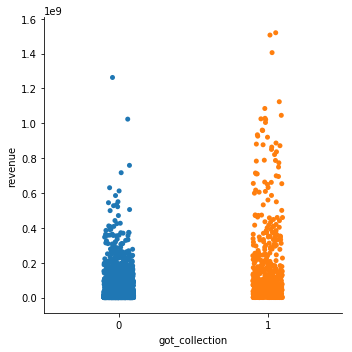

In [13]:
sns.catplot(x='got_collection', y='revenue', data=train);

In [14]:
columns_to_keep.add('got_collection')

#### Explore: budget vs revenue

In [15]:
train.budget.describe()

count    3.000000e+03
mean     2.253133e+07
std      3.702609e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+06
75%      2.900000e+07
max      3.800000e+08
Name: budget, dtype: float64

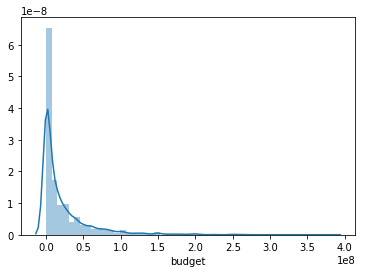

In [16]:
sns.distplot(train['budget'])

Budget data is positively skewed,so to normalise ,we'll take log of it

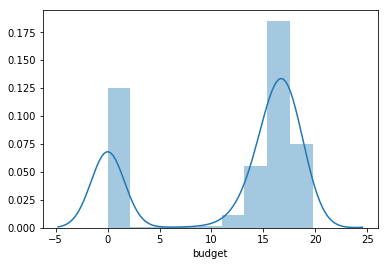

In [17]:
sns.distplot(np.log1p(train['budget']))

We can see many values with very less budget,let's confirm with numbers

In [18]:
len(train[train['budget']==0])

812

So we may have to fill these values.Because making movie with 0 budget is not possible.
We will check how to fill these missing values later(After analysing other columns)

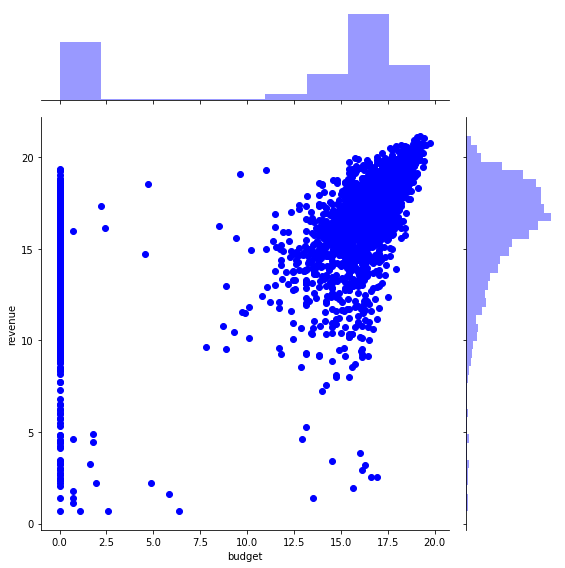

In [19]:
sns.jointplot(x=np.log1p(train['budget']), y=np.log1p(train['revenue']), data=train, height=8, ratio=4, color="b")

There is linear relationship between budget and revenue.Let's find strenght of correlation 
between these two variables using Pearson
correlation

In [20]:
train['budget_log'] = np.log1p(train.budget.values)
test['budget_log'] = np.log1p(test.budget.values)

In [21]:
columns_to_keep.add('budget_log')

In [22]:
train.revenue.corr(train.budget_log,method='pearson')

0.3259246420470963

#### Explore: original_language vs revenue

In [23]:
train.original_language.describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

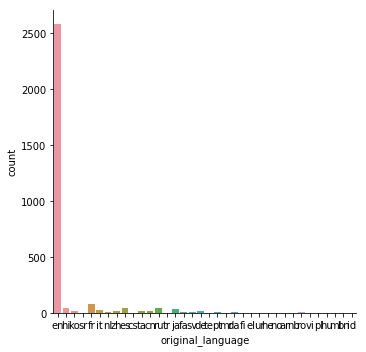

In [24]:
sns.catplot('original_language',data=train,kind='count')

There is data for 36 languages but majority(2500+)movies in English

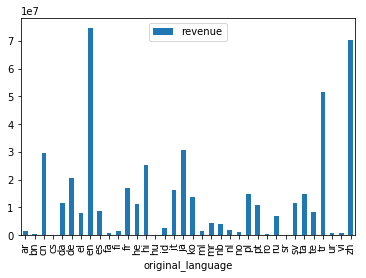

In [25]:
train.groupby(['original_language']).mean()[['revenue']].plot(kind='bar')

English(en),Chinese(zh),Turkish(tr) movies have high revenue per movie compared to other languages

We can create new feature if movie belongs to one of these three-English(en),Chinese(zh),Turkish(tr)

In [26]:
train['belongs_to_three_lang'] = train.original_language.apply(lambda x:1 if str(x) in['en','zh','tr'] else 0)
test['belongs_to_three_lang'] = test.original_language.apply(lambda x:1 if str(x) in['en','zh','tr'] else 0)

In [27]:
columns_to_keep.add('belongs_to_three_lang')

We will encode these values(not one hot encoding)

In [28]:
le = LabelEncoder()
le.fit(list(train['original_language'].fillna('')) + list(test['original_language'].fillna('')))
train['original_language_encoded'] = le.transform(train['original_language'].fillna('').astype(str))
test['original_language_encoded'] = le.transform(test['original_language'].fillna('').astype(str))

In [29]:
columns_to_keep.add('original_language_encoded')

#### Explore:original_title vs revenue

In [30]:
train.original_title.describe()

count       3000
unique      2975
top       Sahara
freq           2
Name: original_title, dtype: object

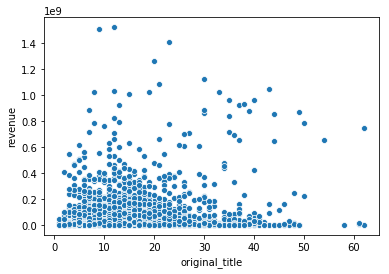

In [31]:
sns.scatterplot(x=train.original_title.str.len(),y=train.revenue)

It looks like positive correlation between title lenght and revenue

In [32]:
train['original_title_length'] = train.original_title.str.len()
test['original_title_length'] = test.original_title.str.len()

In [33]:
train.revenue.corr(train.original_title_length)

0.1175816435574774

In [34]:
columns_to_keep.add('original_title_length')

#### Explore:overview vs revenue

In [35]:
train.overview.describe()

count                                                  2992
unique                                                 2992
top       Elliot, a successful gynecologist, works at th...
freq                                                      1
Name: overview, dtype: object

In [36]:
train.overview[3]

'Vidya Bagchi (Vidya Balan) arrives in Kolkata from London to find her missing husband Arnab Bagchi. Seven months pregnant and alone in a festive city, she begins a relentless search for her husband. With nothing to rely on except fragments from her memories about him, all clues seem to reach a dead end when everyone tries to convince Vidya that her husband does not exist. She slowly realises that nothing is what it seems. In a city soaked in lies, Vidya is determined to unravel the truth about her husband - for herself and her unborn child - even at the cost of her own life.'

I am not sure how overview of movie would be helpful in deciding revenue

#### Explore:popularity vs revenue

In [37]:
train.popularity.describe()

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64

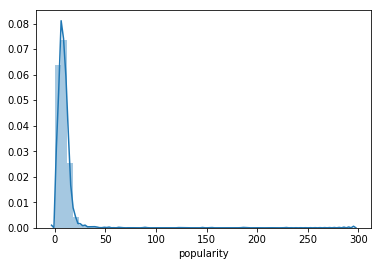

In [38]:
sns.distplot(train.popularity)

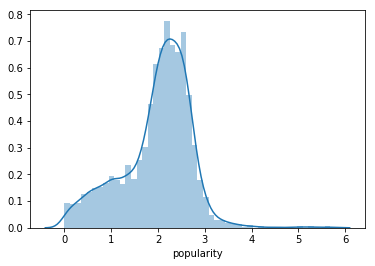

In [39]:
sns.distplot(np.log1p(train.popularity))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fab171f54a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab171f5dd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab171f5358>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab171ff6a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab171ffb00>],
 'means': []}

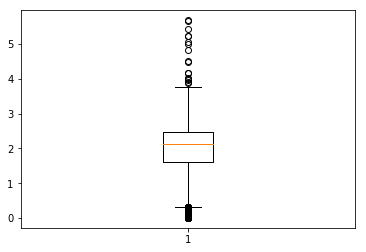

In [40]:
plt.boxplot(np.log1p(train.popularity))

We might need to deal with outliers

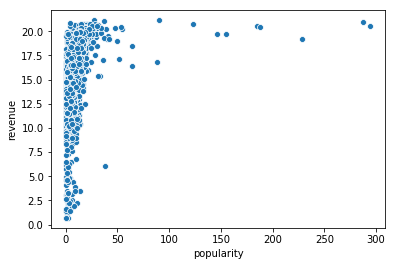

In [41]:
sns.scatterplot(x=train.popularity,y=np.log1p(train.revenue))

In [42]:
train.popularity.corr(train.revenue)

0.4614602896736131

In [43]:
columns_to_keep.add('popularity')

#### Explore:release_date vs revenue

In [44]:
train.release_date.describe()

count        3000
unique       2398
top       9/10/10
freq            5
Name: release_date, dtype: object

In [45]:
#as year is in yy format we have to handle movies after 20xx.So this method will help to add century to year
def clean_date(date):
    year = date.split('/')[2]
    if int(year) <= 19:
        return date[:-2] + '20' + year
    else:
        return date[:-2] + '19' + year

There is one null value in test set

In [46]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '05/01/00'


In [47]:
train['release_date'] = train['release_date'].apply(lambda x:clean_date(x))
test['release_date'] = test['release_date'].apply(lambda x:clean_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [48]:
#get time period features from date value
def date_features(dataset):
    date_sections = ["year", "weekday", "month", 'weekofyear', 'day']
    for sec in date_sections:
        section_col = 'release_date' + "_" + sec
        dataset[section_col] = getattr(dataset['release_date'].dt, sec).astype(int)
        columns_to_keep.add(section_col)
    return dataset



In [49]:
train = date_features(train)
test = date_features(test)

#### Explore:runtime vs revenue

In [50]:
train.runtime.describe()

count    2998.000000
mean      107.856571
std        22.086434
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

In [51]:
train.runtime.isnull().sum()

2

In [52]:
test.runtime.isnull().sum()

4

In [53]:
train.runtime = train.runtime.fillna(np.mean(train.runtime))
test.runtime = test.runtime.fillna(np.mean(test.runtime))

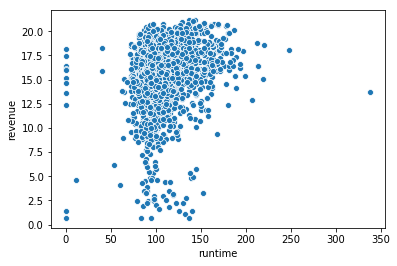

In [54]:
sns.scatterplot(train.runtime,np.log1p(train.revenue))

In [55]:
train.revenue.corr(train.runtime)

0.216363159509536

In [56]:
columns_to_keep.add('runtime')

#### Explore:status vs revenue

In [57]:
train.status.describe()

count         3000
unique           2
top       Released
freq          2996
Name: status, dtype: object

In [58]:
train.status.value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

Only 4 movies are not released,so this feature won't add any value

#### Explore:tagline vs revenue

In [59]:
train.tagline.describe()

count                       2403
unique                      2400
top       Based on a true story.
freq                           3
Name: tagline, dtype: object

In [60]:
train.tagline[:3]

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
Name: tagline, dtype: object

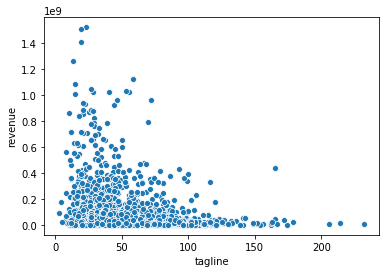

In [61]:
sns.scatterplot(x=train.tagline.str.len(),y=train.revenue)

In [62]:
train['tagline_count'] = train['tagline'].apply(lambda x: 0 if pd.isnull(x) else len(x))
test['tagline_count'] = test['tagline'].apply(lambda x: 0 if pd.isnull(x) else len(x))

In [63]:
columns_to_keep.add('tagline_count')

#### Explore:title vs revenue

In [64]:
train.title.describe()

count                     3000
unique                    2969
top       Beauty and the Beast
freq                         2
Name: title, dtype: object

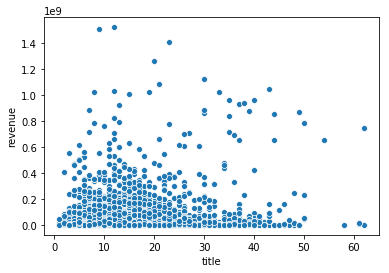

In [65]:
sns.scatterplot(x=train.title.str.len(),y=train.revenue)

In [66]:
train['title_count'] = train['title'].apply(lambda x: 0 if pd.isnull(x) else len(x))
test['title_count'] = test['title'].apply(lambda x: 0 if pd.isnull(x) else len(x))

In [67]:
columns_to_keep.add('title_count')

<a id='features'></a>

## Feature Engineering

Let's create some features based on our intution and domain knowledge

In [68]:
#budget must be high for popular movies
train['budget_popularity'] = train['budget']/train['popularity']
test['budget_popularity'] = test['budget']/test['popularity']
columns_to_keep.add('budget_popularity')

#budget increased since past
train['budget_release_year'] = train['budget']/train['release_date_year']
test['budget_release_year'] = test['budget']/test['release_date_year']
columns_to_keep.add('budget_release_year')

#popularity increased since past
train['popularity_release_year'] = train['popularity']/train['release_date_year']
test['popularity_release_year'] = test['popularity']/test['release_date_year']
columns_to_keep.add('popularity_release_year')

#popularity and day on which movie releases must be related
train['popularity_release_weekday'] = np.sqrt(train['popularity']*train['release_date_weekday'])
test['popularity_release_weekday'] = np.sqrt(test['popularity']*test['release_date_weekday'])
columns_to_keep.add('popularity_release_weekday')

#movies with more generes in it are recently being made
train['genres_number_release_year'] = train['genres_number']/train['release_date_year']
test['genres_number_release_year'] = test['genres_number']/test['release_date_year']
columns_to_keep.add('genres_number_release_year')


#movie runtime reduced w.r.t time
train['runtime_release_year'] = np.sqrt(train['runtime']*train['release_date_year'])
test['runtime_release_year'] = np.sqrt(test['runtime']*test['release_date_year'])
columns_to_keep.add('runtime_release_year')

#high runtime movies may require high budget
train['budget_runtime'] = np.sqrt(train['budget']*train['runtime'])
test['budget_runtime'] = np.sqrt(test['budget']*test['runtime'])
columns_to_keep.add('budget_runtime')

train['budget_tagline_count'] = np.sqrt(train['budget']*train['tagline_count'])
test['budget_tagline_count'] = np.sqrt(test['budget']*test['tagline_count'])
columns_to_keep.add('budget_tagline_count')

## Feature Selection

In [69]:
len(columns_to_keep)

106

We have 106 columns as feature,we will select features according to their importance to revenue

In [70]:
columns_to_keep

{'Keywords_aftercreditsstinger',
 'Keywords_all',
 'Keywords_based on novel',
 'Keywords_biography',
 'Keywords_duringcreditsstinger',
 'Keywords_dystopia',
 'Keywords_independent film',
 'Keywords_murder',
 'Keywords_number',
 'Keywords_sport',
 'Keywords_violence',
 'Keywords_woman director',
 'belongs_to_three_lang',
 'budget_log',
 'budget_popularity',
 'budget_release_year',
 'budget_runtime',
 'budget_tagline_count',
 'cast_Bruce McGill',
 'cast_Bruce Willis',
 'cast_Forest Whitaker',
 'cast_J.K. Simmons',
 'cast_John Turturro',
 'cast_Liam Neeson',
 'cast_Morgan Freeman',
 'cast_Robert De Niro',
 'cast_Samuel L. Jackson',
 'cast_Susan Sarandon',
 'cast_all',
 'cast_number',
 'crew_Avy Kaufman',
 'crew_Deborah Aquila',
 'crew_Francine Maisler',
 'crew_James Newton Howard',
 'crew_Jerry Goldsmith',
 'crew_Luc Besson',
 'crew_Mary Vernieu',
 'crew_Robert Rodriguez',
 'crew_Steven Spielberg',
 'crew_Tricia Wood',
 'crew_all',
 'crew_number',
 'genres_Action',
 'genres_Adventure',
 '

let's categorize these features which will simplify further analysis

In [71]:
numerical_features = ['Keywords_number','runtime','spoken_languages_number','production_countries_number',
                     'production_companies_number','popularity','genres_number','crew_number','cast_number','budget_log',
                     'budget_popularity','budget_release_year','popularity_release_year','popularity_release_weekday',
                     'genres_number_release_year','runtime_release_year','budget_runtime','budget_tagline_count']
date_features = ['release_date_day','release_date_month','release_date_weekday','release_date_weekofyear',
                        'release_date_year']
feature_text_length = ['title_count','tagline_count','original_title_length']
categorical_features = ['spoken_languages_all','production_companies_all','production_countries_all','original_language',
                       'got_collection','genres_all','crew_all','cast_all','belongs_to_three_lang','Keywords_all']
spoken_language_features = ['spoken_languages_','spoken_languages_Deutsch','spoken_languages_English','spoken_languages_Español',
                             'spoken_languages_Français','spoken_languages_Italiano', 'spoken_languages_Pусский',
                            'spoken_languages_हिन्दी','spoken_languages_日本語','spoken_languages_普通话']
production_countries_features = ['production_countries_Australia','production_countries_Canada','production_countries_France',
                                'production_countries_Germany','production_countries_India','production_countries_Italy',
                                'production_countries_Japan','production_countries_Russia','production_countries_United Kingdom',
                                'production_countries_United States of America' ]
production_companies_features = ['production_companies_Columbia Pictures','production_companies_Columbia Pictures Corporation',
                                 'production_companies_Metro-Goldwyn-Mayer (MGM)', 'production_companies_New Line Cinema',
                                 'production_companies_Paramount Pictures', 'production_companies_Touchstone Pictures',
                                 'production_companies_Twentieth Century Fox Film Corporation','production_companies_Universal Pictures',
                                 'production_companies_Walt Disney Pictures', 'production_companies_Warner Bros.']
genres_features = ['genres_Action', 'genres_Adventure','genres_Comedy', 'genres_Crime', 'genres_Drama', 'genres_Family',
                 'genres_Horror', 'genres_Romance', 'genres_Science Fiction', 'genres_Thriller']
crew_features = ['crew_Avy Kaufman', 'crew_Deborah Aquila', 'crew_Francine Maisler','crew_James Newton Howard',
                 'crew_Jerry Goldsmith', 'crew_Luc Besson', 'crew_Mary Vernieu', 'crew_Robert Rodriguez','crew_Steven Spielberg',
                 'crew_Tricia Wood']
cast_features = ['cast_Bruce McGill', 'cast_Bruce Willis','cast_J.K. Simmons','cast_John Turturro','cast_Liam Neeson',
                 'cast_Morgan Freeman','cast_Robert De Niro','cast_Samuel L. Jackson', 'cast_Susan Sarandon','cast_Willem Dafoe']
keywords_features = ['Keywords_aftercreditsstinger', 'Keywords_based on novel', 'Keywords_biography',
                     'Keywords_duringcreditsstinger', 'Keywords_independent film', 'Keywords_murder',
                     'Keywords_revenge', 'Keywords_sport', 'Keywords_violence', 'Keywords_woman director']


In [72]:
print(len(numerical_features)+len(date_features)+len(feature_text_length)+len(categorical_features)+len(spoken_language_features)
+len(production_countries_features)+len(production_companies_features)+len(genres_features)+len(crew_features)+len(cast_features)
+len(keywords_features))

106


#### Numerical features

In [73]:
numerical_data = numerical_features
numerical_data.append('revenue')

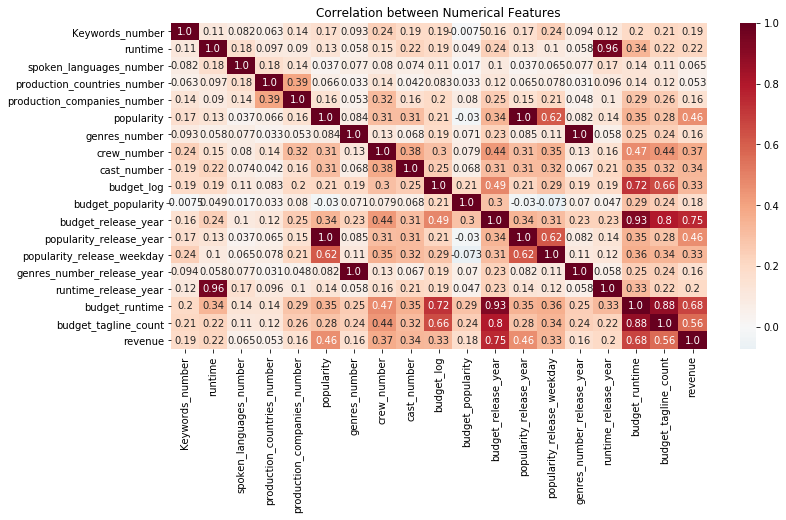

In [74]:
plt.figure(figsize=(12,6))
sns.heatmap(train[numerical_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between Numerical Features')
plt.show()

###### inferences

1.'revenue' is dependant on all numerical features we selected except 'spoken_languages_number','production_countries_number'<br>
2.'popularity' is highly corelated to 'popularity_release_weekday','popularity_release_year',So keep 1 of 3<br>
3.'generes_number' is highly corelated to 'generes_number_release_year'.So either one of them can be removed<br>
4.'runtime' is highly corelated to 'runtime_release_year'.So either one of them can be removed<br>

#### date features

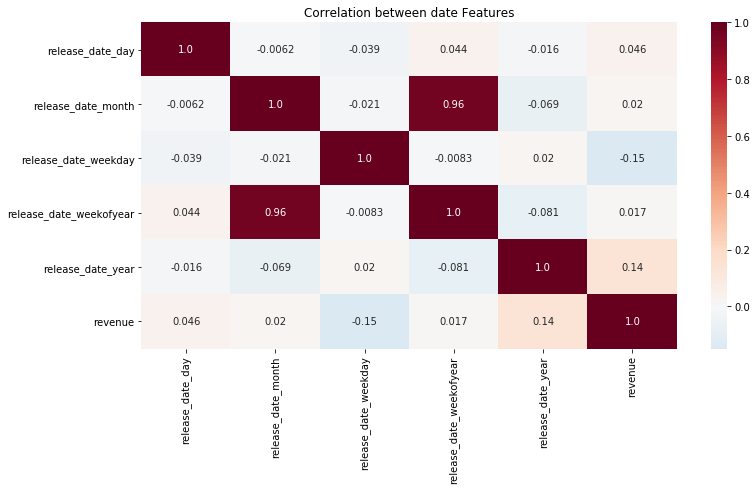

In [75]:
date_data = date_features
date_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[date_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between date Features')
plt.show()

###### inferences

1.'revenue' is moderately related to year,day of the week.It makes sense movies usually release on Friday.

#### text length features

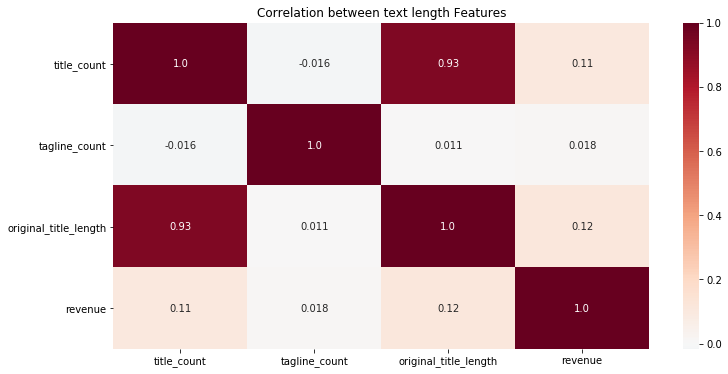

In [76]:
text_length_data = feature_text_length
text_length_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[text_length_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between text length Features')
plt.show()

###### inferences

1.'revenue' is moderately correlated to 'original_title_length','title_count'<br>
2.'original_title_length' and 'title_count' are highly correlated.Either one of them can be dropped.

#### categorical_features

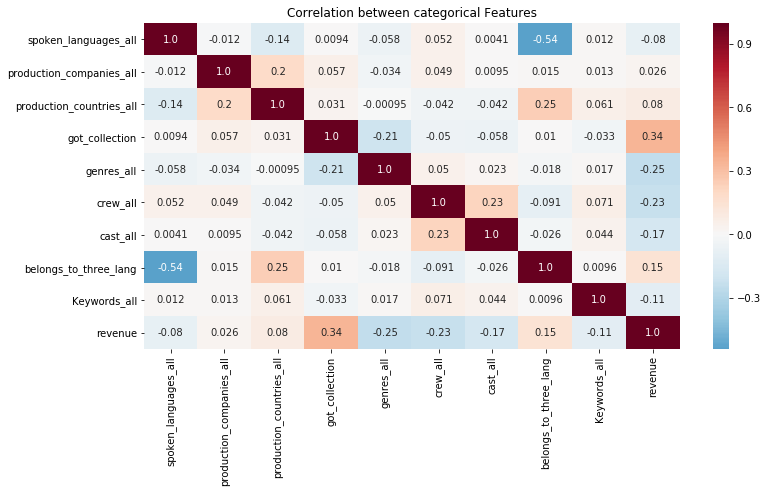

In [77]:
categorical_features_data = categorical_features
categorical_features_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[categorical_features_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between categorical Features')
plt.show()

###### inferences

1.'revenue' is moderately correlated to 'Keywords_all','crew_all','cast_all','got_collection','genres_all'

#### spoken_language_features

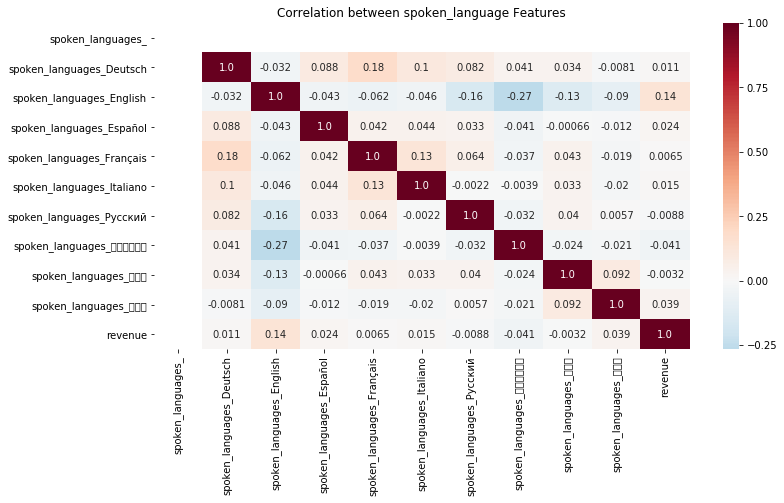

In [78]:
spoken_language_features_data = spoken_language_features
spoken_language_features_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[spoken_language_features_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between spoken_language Features')
plt.show()

###### inferences

1.'revenue' is moderately correlated to 'spoken_languages_English'

#### production_countries_features

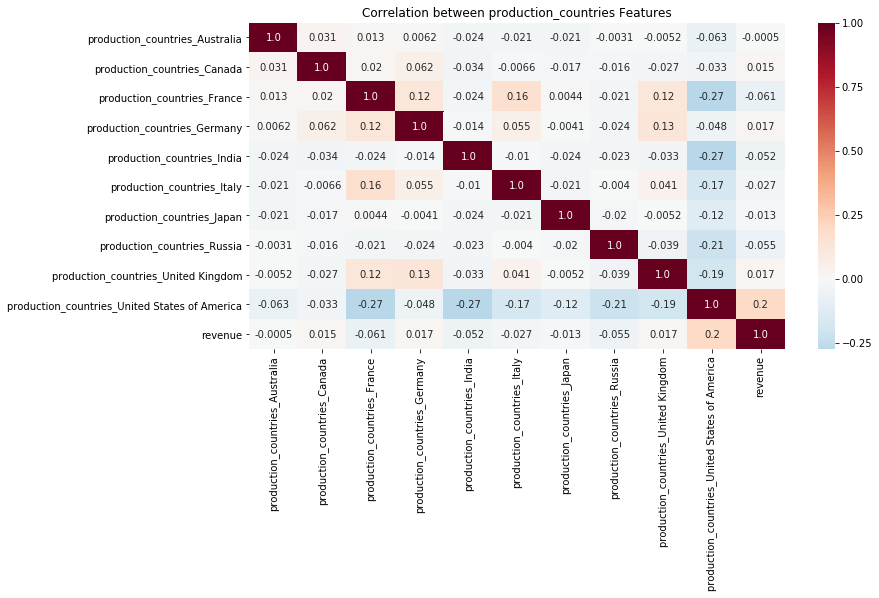

In [79]:
production_countries_features_data = production_countries_features
production_countries_features_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[production_countries_features_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between production_countries Features')
plt.show()

###### inferences

1.'revenue' is moderately correlated to 'production_countries_United States of America'

#### production_companies_features features

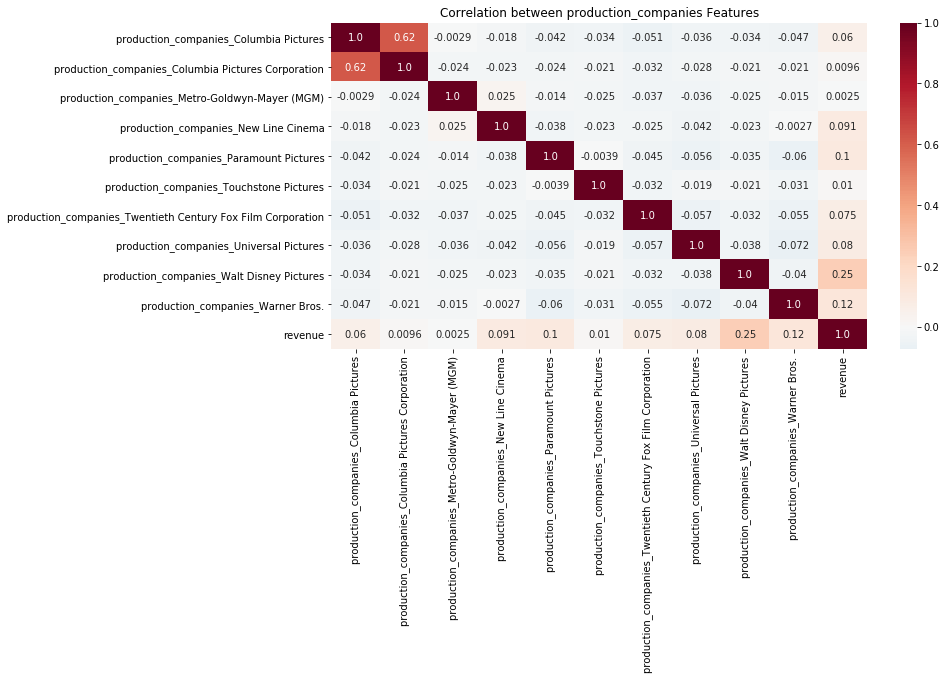

In [80]:
production_companies_features_data = production_companies_features
production_companies_features_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[production_companies_features_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between production_companies Features')
plt.show()

###### inferences

1.'revenue' is moderately correlated to 'production_companies_Paramount Pictures','production_companies_Walt Disney Pictures', 'production_companies_Warner Bros.'

#### genres_features  

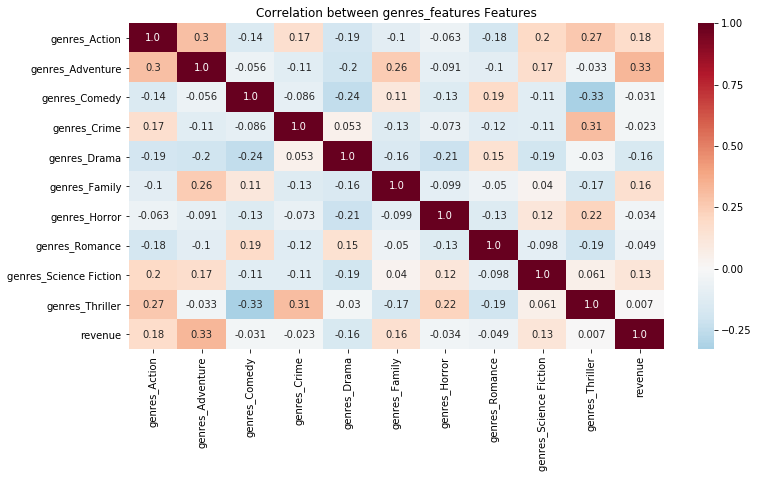

In [81]:
genres_features_data = genres_features
genres_features_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[genres_features_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between genres_features Features')
plt.show()

###### inferences

1.'revenue' is moderately correlated to 'genres_Action', 'genres_Adventure','genres_Drama', 'genres_Family',
                  'genres_Science Fiction'

#### crew_features 

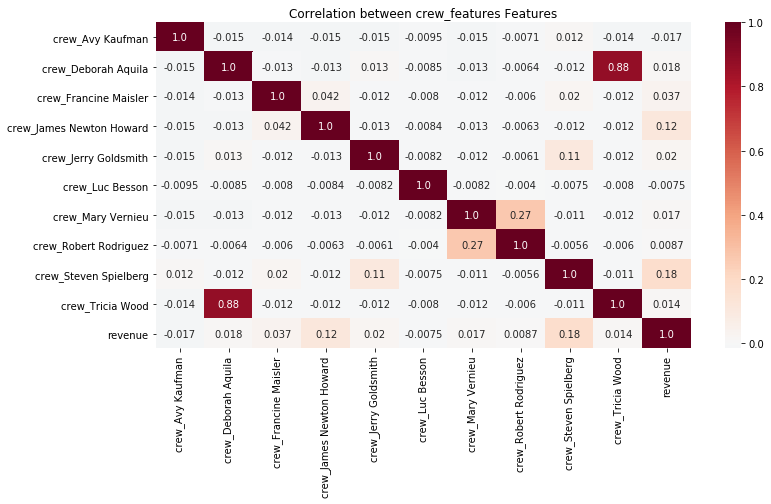

In [82]:
crew_features_data = crew_features
crew_features_data.append('revenue')
plt.figure(figsize=(12,6))
sns.heatmap(train[crew_features_data].corr(), annot=True, fmt='.2', center=0.0, cmap='RdBu_r')
plt.title('Correlation between crew_features Features')
plt.show()

###### inferences

1.'revenue' is moderately correlated to 'crew_Steven Spielberg'

Let's get top 50 features out of 106 features depending on correlation with revenue

In [83]:
corr_features = list(columns_to_keep)
corr_features.append('revenue')
corrs = abs(train[corr_features].corr()['revenue']).sort_values(ascending=False)
corr_selected_features = corrs[:50].index.tolist()
corr_selected_features.remove('revenue')
#corr_selected_features

<a id='model'></a>

## Model and Evaluation

We will find best parameters for models

In [84]:
def select_model(X_train, X_val, y_train, y_val):

    best_models = {}
    models = [
        {
            'name': 'LinearRegression',
            'estimator': LinearRegression(),
            'hyperparameters': {},
        },
       
        {
            'name': 'GradientBoostingRegressor',
            'estimator': GradientBoostingRegressor(),
            'hyperparameters':{
                'n_estimators': range(100, 200, 10),
                'criterion': ['friedman_mse'],
                'max_depth': [3, 5, 7, 9],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [3, 5, 7]
            }
            
        },

        {
            'name': 'XGBoost',
            'estimator': xgb.XGBRegressor(),
            'hyperparameters':{
                'booster': ['gbtree', 'gblinear', 'dart'],
                'max_depth': range(5, 50, 5),
                'n_estimators': [200],
                'nthread': [4],
                'min_child_weight': range(1, 8, 2),
                'learning_rate': [.05, .1, .15],
            }
        },
        {
            'name': 'Light GBM',
            'estimator': lgb.LGBMRegressor(),
            'hyperparameters':{
                'max_depth': range(20, 85, 15),
                'learning_rate': [.01, .05, .1],
                'num_leaves': [300, 600, 900, 1200],
                'n_estimators': [200]
            }
        }
    ]
    
    for model in tqdm(models):
        print('\n', '-'*25, '\n', model['name'])
        start = time.perf_counter()
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=5, scoring = "neg_mean_squared_error", verbose=False, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[model['name']] = {'score': grid.best_score_, 'params': grid.best_params_}
        mse_val = mean_squared_error(y_val, grid.predict(X_val))
        mse_train = mean_squared_error(y_train, grid.predict(X_train))
        print("RMSLE train:{}".format(np.sqrt(mse_train))) 
        print("RMSLE validation:{}".format(np.sqrt(mse_val)))
        print("best_params_:{}".format(grid.best_params_))
        run = time.perf_counter() - start
        
        
    return best_models

In [85]:
def get_best_parameters(train,features_list):

    X_train = train[features_list]
    y_train = np.log1p(train["revenue"]).values
      
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

    models = select_model(X_train, X_val, y_train, y_val)
    return models

In [86]:
# A class that will define all the regression models as methods

class Models(object):
    
    
    
    # Initialization 
    def __init__(self, x_train, x_validation, y_train, y_validation):
        # changing input as dataframe to list
        self.x_train = [x_train.iloc[i].tolist() for i in range(len(x_train))]
        self.x_validation = [x_validation.iloc[i].tolist() for i in range(len(x_validation))]
        self.y_train = y_train.tolist()
        self.y_validation = y_validation.tolist()
        
    
    
    @staticmethod
    def print_info(cross_val_scores, mse_train,mse_val):
        print("Cross Validation Scores: ", cross_val_scores)
        print("RMSLE train:{}".format(np.sqrt(mse_train))) 
        print("RMSLE validation:{}".format(np.sqrt(mse_val)))
        #print("Mean Squared Error: ", np.sqrt(mse))
        
        
  
    # Gradient Boosting Regressor
    def GBR(self, x_train, x_validation,  y_train, y_validation):
        gbr = GradientBoostingRegressor(n_estimators=120, learning_rate=0.08,max_features='sqrt',criterion='friedman_mse',
                                        min_samples_leaf=1,min_samples_split=3, max_depth=7, random_state=seed)
        gbr.fit(self.x_train, self.y_train)
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(gbr, self.x_train, self.y_train, cv=kfold)
        mse_val = mean_squared_error(self.y_validation, gbr.predict(self.x_validation))
        mse_train = mean_squared_error(self.y_train, gbr.predict(self.x_train))
        print('\nGradient Boosting Regressor')
        self.print_info(cross_val_scores, mse_train,mse_val)
        return cross_val_scores, mse_val, gbr
    
    
    # LGBM Regressor 
    def lgbm(self, x_train, x_validation,  y_train, y_validation):
        lgbm =lgb.LGBMRegressor(n_estimators=10000,objective="regression", metric="rmse",num_leaves=20, 
                             min_child_samples=100,learning_rate=0.01, bagging_fraction=0.8,feature_fraction=0.8, 
                             bagging_frequency=1,importance_type='gain', bagging_seed=seed,subsample=.9, 
                             colsample_bytree=.9,use_best_model=True)
                                
        lgbm.fit(x_train, y_train,eval_set=(x_validation, y_validation),verbose=False)
    
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(lgbm, self.x_train, self.y_train, cv=kfold)
        mse_val = mean_squared_error(self.y_validation, lgbm.predict(self.x_validation))
        mse_train = mean_squared_error(self.y_train, lgbm.predict(self.x_train))
        print('\nLGBM Regressor')
        self.print_info(cross_val_scores, mse_train,mse_val)
        return cross_val_scores, mse_val, lgbm
    
    
    # XgBoost Regressor 
    def xgBoost(self, x_train, x_validation,  y_train, y_validation):
        params = {'objective': 'reg:linear','eta': 0.01,'max_depth': 6,'subsample': 0.6,'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 'seed': seed,'silent': True,}
    
        record = dict()
        xg = xgb.train(params, xgb.DMatrix(x_train, y_train), 100000, [(xgb.DMatrix(x_train, y_train), 'train'),
                                                                      (xgb.DMatrix(x_validation, y_validation), 'valid')]
                      , verbose_eval=False, early_stopping_rounds=500, callbacks = [xgb.callback.record_evaluation(record)])
        best_idx = np.argmin(np.array(record['valid']['rmse']))
    
        #kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
        #cross_val_scores = cross_val_score(xg, self.x_train, self.y_train, cv=kfold)
        cross_val_scores= 0
        mse_val = mean_squared_error(self.y_validation, xg.predict(xgb.DMatrix(x_validation), ntree_limit=xg.best_ntree_limit))
        mse_train = mean_squared_error(self.y_train, xg.predict(xgb.DMatrix(x_train), ntree_limit=xg.best_ntree_limit))
        print('\nXgBoost Regressor')
        self.print_info(cross_val_scores, mse_train,mse_val)
        #plot_importance(xg)
        #plt.show()
        return cross_val_scores, mse_val, xg

In [87]:
def evaluate_models(train, test,features_list):

    X_train = train[features_list]
    y_train = np.log1p(train["revenue"]).values
      
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

    methods = [x for x, y in Models.__dict__.items() if type(y) == FunctionType]
    methods.remove('__init__')
    # Now calling the all regression methods
    cross_scores_list, mse_list = [], []
    models = {}
    for model in methods:
        reg = Models(X_train, X_val, y_train, y_val)
        cross_val_scores, mse, return_model = getattr(reg, model)(X_train, X_val, y_train, y_val)
        cross_scores_list.append(cross_val_scores)
        models[model] = return_model
        mse_list.append(mse)
    return models

In [88]:
#get_best_parameters(train,list(columns_to_keep))

In [89]:
#Evaluate models with best parameters and top 50 features based on correlation
corr_features_models = evaluate_models(train, test,corr_selected_features)


Gradient Boosting Regressor
Cross Validation Scores:  [0.55628967 0.37370329 0.51520052 0.47130727 0.42548083 0.5230004
 0.50498906 0.48786952 0.53710325 0.52546348]
RMSLE train:0.7187598532756353
RMSLE validation:1.9105678252814158

LGBM Regressor
Cross Validation Scores:  [0.45505772 0.33071342 0.43078545 0.39780505 0.43206271 0.46608148
 0.46029968 0.44682152 0.52671387 0.50140886]
RMSLE train:0.43410868799489694
RMSLE validation:2.0289911340096363

XgBoost Regressor
Cross Validation Scores:  0
RMSLE train:1.0544950473253902
RMSLE validation:1.906092355090316


In [90]:
#Evaluate models with best parameters and  all features we created so far
all_features_models = evaluate_models(train, test,list(columns_to_keep))


Gradient Boosting Regressor
Cross Validation Scores:  [0.55457319 0.40090616 0.5315205  0.45771682 0.41919194 0.58471857
 0.51259847 0.47721839 0.54205151 0.5011127 ]
RMSLE train:0.6555257584292096
RMSLE validation:1.9049401510729982

LGBM Regressor
Cross Validation Scores:  [0.48218749 0.3070345  0.43242919 0.35218858 0.38679398 0.51429708
 0.46893537 0.44590133 0.51851422 0.44779761]
RMSLE train:0.3365905538593892
RMSLE validation:1.9876885873240828

XgBoost Regressor
Cross Validation Scores:  0
RMSLE train:0.5185088954084547
RMSLE validation:1.879914785124274


So it turns out all features we created so far give less RMSLE

<a id='submit'></a>

## Submission

In [91]:
def calculate_test_results(models,test,model_names,features_list):
        
    X_test = test[features_list]
    pred = np.empty(shape=len(X_test)).tolist()
    
    for model in model_names:
        mod = models[model]
        if(model=='xgBoost'):
            pred = pred + np.expm1(mod.predict(xgb.DMatrix(X_test), ntree_limit=mod.best_ntree_limit))
        else:   
            pred = pred + np.expm1(mod.predict(X_test))
    
    return pred

In [92]:
xgBoost_results = calculate_test_results(all_features_models,test,['xgBoost'],list(columns_to_keep))
gbr_results = calculate_test_results(all_features_models,test,['GBR'],list(columns_to_keep))
lgbm_results = calculate_test_results(all_features_models,test,['lgbm'],list(columns_to_keep))

#final_pred = 0.4*xgBoost_results + 0.4*gbr_results + 0.2*lgbm_results  2.11835
#final_pred = 0.7*xgBoost_results + 0.3*gbr_results 2.05313
#final_pred = 0.3*xgBoost_results + 0.7*gbr_results 2.10757
#final_pred = 0.6*xgBoost_results + 0.2*gbr_results + 0.2*lgbm_results  2.06723
#final_pred = 0.8*xgBoost_results + 0.2*gbr_results 2.05289
final_pred = 0.8*xgBoost_results + 0.2*lgbm_results 
#final_pred = 0.9*xgBoost_results + 0.1*gbr_results
#final_pred = xgBoost_results  2.05923

submission = pd.DataFrame()
submission['id'] = test['id']
submission['revenue'] = final_pred
submission.to_csv('submission.csv', index=False)

Thanks for reading through.Please upvote,comment if you liked it